<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/Copy_of_Overall_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here, we are trying to see if using LSTM can help predict the price of bitcoin

Import Needed *Libraries*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bitcoin=pd.read_csv("bitcoin.csv")


Overall View of Dataset


In [ ]:
bitcoin.head(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Clean up the data and use certain variables such as 'High','Low', and Timestamp. Do note that I am using the average of hight and low, thus the values have been added up and divided by 2


In [ ]:
bitcoin['price'] = (bitcoin['High']+ bitcoin['Low'])/2
bitcoin.drop(['Open','Close','Volume_(BTC)','Volume_(Currency)', 'Weighted_Price','High','Low'],axis=1, inplace=True)

bitcoin['Timestamp'] = pd.to_datetime(bitcoin['Timestamp'],unit='s')
bitcoin = bitcoin.set_index('Timestamp')
bitcoin = bitcoin.resample('6H').mean()
bitcoin = bitcoin.dropna()


View data after unnesserry data has been dropped

In [ ]:
bitcoin.head(10)

,price
Timestamp,
2011-12-31 06:00:00,4.390000
2011-12-31 12:00:00,4.501667
2012-01-01 00:00:00,4.580000
2012-01-01 12:00:00,4.840000
2012-01-01 18:00:00,5.000000
2012-01-02 18:00:00,5.000000
2012-01-03 06:00:00,5.320000
2012-01-03 12:00:00,5.242857
2012-01-04 00:00:00,4.930000


View of what the data looks like in plt plot

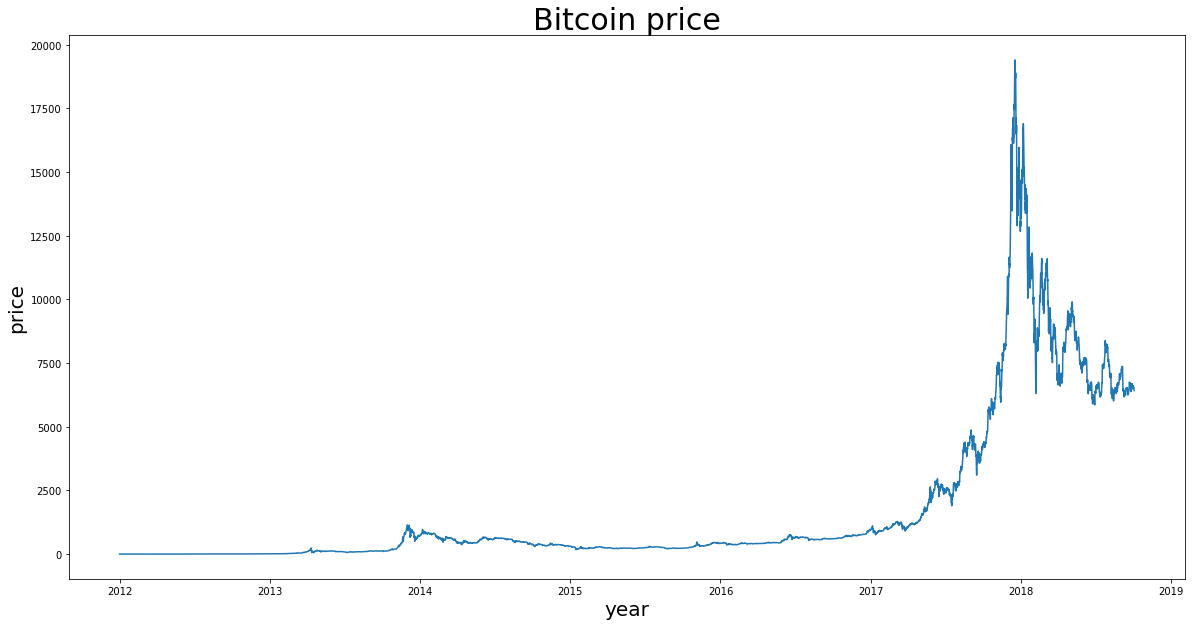

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(bitcoin)
plt.title('Bitcoin price',fontsize=30)
plt.xlabel('year',fontsize=20)
plt.ylabel('price',fontsize=20)
plt.show()

Additional Information about the data for better understanding

In [ ]:
price = bitcoin['price']
max_value = price.max()
min_value = price.min()
avg_value=price.mean()

print(max_value, ' is the maximum  price of bitcoin ')
print(min_value,  ' is the minimum price of bitcoin')
print(avg_value, 'is the average price of bitcoin')

19396.67961111111  is the maximum  price of bitcoin 
4.263125  is the minimum price of bitcoin
1765.5587368908168 is the average price of bitcoin


Using Scalar to get values in 0's and 1's for price

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import models, layers

In [ ]:
scaler = MinMaxScaler()
price = scaler.fit_transform(np.array(bitcoin['price']).reshape(-1,1))
bitcoin['price'] = price

Testing 1 date based on what done above to check if code works. In this test I will predict price for 1 date based on price of 100 dates.

In [ ]:
X_l = []
y_l = []
Number = len(bitcoin)
Dates = 100
for i in range(Number-Dates-1):
    X_l.append(bitcoin.iloc[i:i+Dates])
    y_l.append(bitcoin.iloc[i+Dates])
    
X = np.array(X_l)
y = np.array(y_l)

print(X.shape, y.shape)

# 12646 is the price for 1 day based on 100 days

(9636, 100, 1) (9636, 1)


Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 100)

 Model for Overall Dataset

In [ ]:
m_x = layers.Input(shape = X_train.shape[1:])
m_h = layers.LSTM(10)(m_x)
m_y = layers.Dense(1)(m_h)
m = models.Model(m_x,m_y)
m.compile('adam','mse')
m.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


Evaluate model (100 times)


In [ ]:
history = m.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),verbose=0)

Show Model

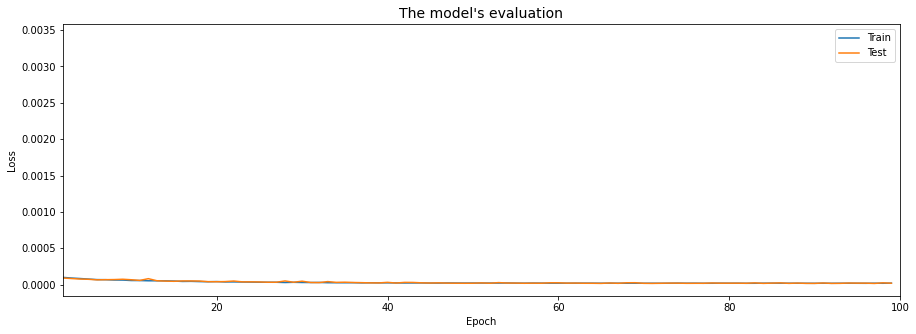

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','Test'])
plt.title("The model's evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.xlim(2,100)
plt.ylabel('Loss')
plt.show()

Predict price on 200 values

In [ ]:
pred =[]

pr = m.predict(np.array(bitcoin[-40:]))

pred.append(pr[0])

for i in range(1,40):
    pr = m.predict(np.concatenate((np.array(bitcoin[-40+i:]), pred[:]), axis=0))
    pred.append(pr[0])

for i in range(0,160):
    pr = m.predict(np.concatenate(pred[i:],axis=0).reshape(-1,1))
    pred.append(pr[0])

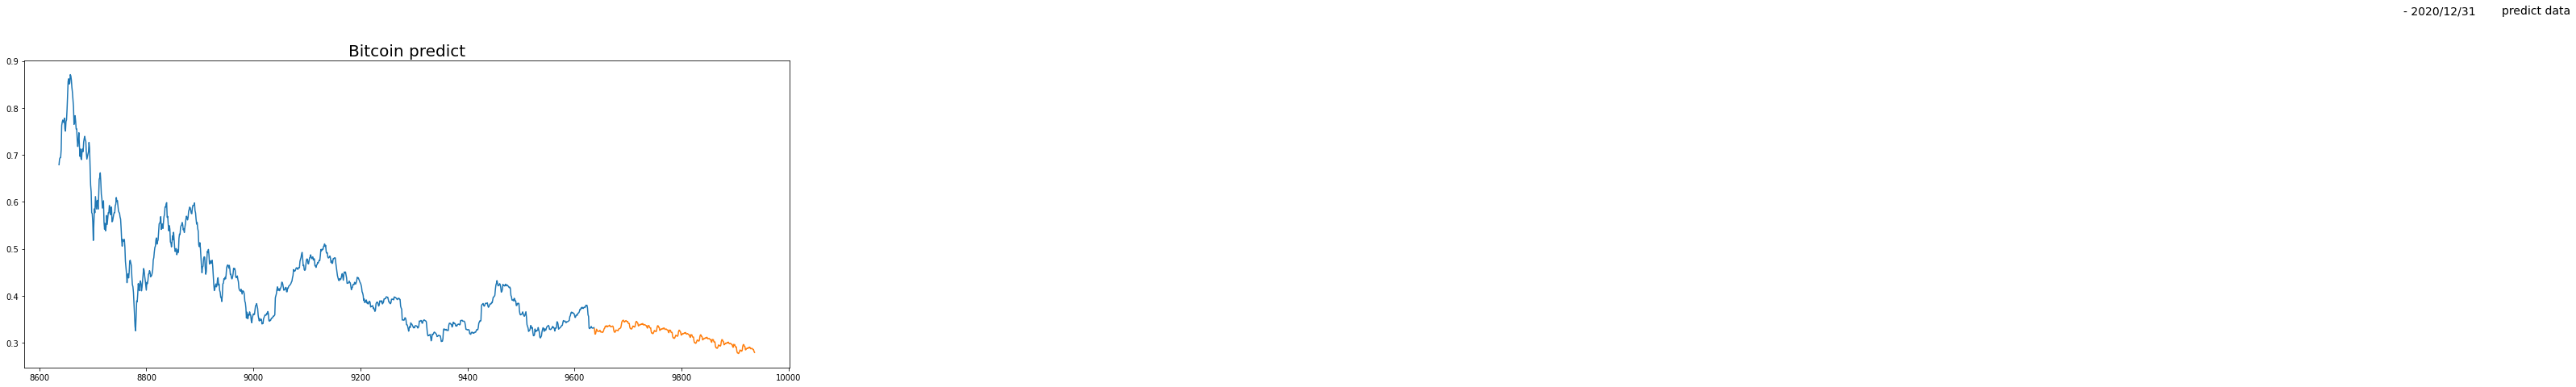

In [ ]:
pred = pd.DataFrame(pred)

pred = pred.reset_index()

pred.columns = ['z','price']

pred.drop(['z'],axis=1,inplace=True)

data = pd.concat([bitcoin.reset_index().drop('Timestamp',axis=1),pred],ignore_index=True)

plt.figure(figsize=(17,7))
plt.plot(data[-1300:-300])
plt.title("Bitcoin predict",fontsize=20)
plt.text(13200,1,"predict data",fontsize=14)
plt.text(13015,1,"- 2020/12/31",fontsize=14)
plt.plot(data[-300:])
plt.show()

When looking at the overall results, it is clear that we cannot predict the price of bitcoin with this model. But what if we break the model down to 2 parts and see if the results are better